# Goal of this notebook
Without ever having to read a single tweet, we want to be able to know how the general sentiment in the fanbase of a team throughout the year 2019. <br>
In order to be able to do this we need:
#### Models:
- A language model, thatunderstands how a language is structured and will understand context
- A classifier: another model that labels each tweet as either positive or negative

#### Datset:
- Tweets from each NBA team throughout the year 2019
- Tweets that are already labelled as positive or negative to train (&test) our classifier on

# Approach
Using the [twitterscraper library](https://pypi.org/project/twitterscraper/0.2.7/) I downloaded over 250k tweets with about 9k per team which were all tweeted throughout the year 2019.
This will be the dataset we later predict on for which we currently don't have any positive or negative labels.<br>
As training set for our classifier we will use the [sentiment140](https://www.kaggle.com/kazanova/sentiment140) dataset which has 1.6 million labelled tweets.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import os
import time

### Preprocessing tweets
I ran the scraping commands from the terminal which left me with a JSON file for each time, which in the following code cell were just concatenated into one large dataframe. We also only keep the timestamp and text, which are the only columns of interest to us for this project.

In [3]:
json_files = [file for file in os.listdir() if file.endswith('json')]
json_files

df_list = []

for filestring in json_files:
    with open(filestring) as json_file:
        data = (pd.DataFrame(json.load(json_file))[['timestamp', 'text']]
                                .assign(team=filestring.split('.json')[0]))

        df_list.append(data)

df = pd.concat(df_list)
df.to_csv('team_tweets.csv')

## The first stage: The language model
A language model essentially is a model that is trying to predict the next word in a sentence. This model will automatically learn the structure of a language. A good language model for example will use the correct pronouns based on whether names in the sentence are male or female. <br>
In other words, the language model learns quite a lot about the concept of a language which is an important part of understanding the general mood behind a statement.<br>
Therefore it will be incredibly useful as a starting point for our classifier.

In this special case, where our training set for the classifier is going to be a different corpus than our corpus that we will predict on (sentiment140 vs. my scraped NBA tweets), it seems to be best idea to mix both datasets into our language model. Therefore we will feed 125,000 tweets of each dataset into the model. The number is chosen kind of arbitrarily, but mostly for the purpose of the model to fit quickly.
It's also important to know, that we just built on a model, that is already part of the fastai library and was trained on the [WikiText103](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) dataset, which is a huge subset of Wikipedia articles. So the model already knows quite a lot but then gets additional input from our tweets, which will retrain its final layers a bit.

In [5]:
path = Path(os.getcwd())
nba_tweets = (pd.read_csv('team_tweets.csv', engine='python')
              .dropna()
              .sample(125000, random_state=1)
              .reset_index(drop=True).drop(['index'], axis=1))

In [6]:
# !kaggle datasets download -d kazanova/sentiment140
# !unzip sentiment140.zip -d {os.getcwd()}
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_sent = pd.read_csv(path/'training.1600000.processed.noemoticon.csv', 
                           encoding=encoding,
                           low_memory=False, 
                           names=col_names)[['target', 'text']].dropna().sample(125000, random_state=1)

In [8]:
df = pd.concat([nba_tweets.assign(target=0)[['target', 'text']],
                twitter_sent]).reset_index(drop=True)
training_sample = df.sample(frac=0.9).index

In [11]:
# creating the databunch for the language model. This automatically produces a vocabulary, which we will later
# see again in the classifier
data_lm = TextLMDataBunch.from_df(path, train_df=df.loc[training_sample], 
                               valid_df=df.drop(training_sample))
data_lm.show_batch()

idx,text
0,he ’s the goat xxbos @silver_craig hey xxunk ! i 'm back from xxmaj italy . xxbos does n't want to go back to work tomorrow xxbos & ' xxmaj the man who ca n't be moved & ' - xxmaj the xxmaj script xxbos i had better go to bed if i 'm going to school tomorrow . xxmaj good xxmaj night everyone xo xxbos @utahjazz i 'm thinking
1,xxmaj reuters … xxbos xxmaj finished xxmaj halo xxmaj wars . xxmaj sadly there was no ending xxunk race . xxbos @dwyanewade xxmaj happy 37th xxmaj birthday young dawg glad to see you play tomorrow against my xxmaj detroit xxmaj pistons but good luck hopefully i can get the game jersey # onelastdance # idol xxbos i just attempted to watch the xxmaj clippers game tonight against xxmaj utah
2,"xxmaj jokic 's xxup dgaf level , and xxmaj denver 's depth . \n \n … xxbos xxmaj maybe there 4th at best xxunk if you disagree its pure nonsense xxbos @ddlovato bride wars is n't embarassing ! we 're girls , we 're allowed to watch chick flicks , cry , and wish to get married at the plaza hotel ! xxbos xxmaj indiana xxmaj pacers tickets are"
3,xxmaj forcier has been hired as an assistant coach with the xxmaj milwaukee xxmaj bucks . xxmaj back with xxmaj coach xxmaj bud ! # xxunk xxbos i 'm being drowned by the xxunk of a big white cat . xxmaj help me xxmaj help me ! xxbos xxmaj report : xxmaj kyrie xxmaj irving to miss first game in xxmaj boston since leaving xxmaj celtics pic.twitter.com / xxunk
4,"hard enough to hang out with you . because i 'd really like to . a lot xxbos xxmaj great team effort xxbos xxmaj so happy for xxmaj aron xxmaj baynes , he deserves all the credit . \n \n xxmaj now imagine this xxmaj celtics team with xxmaj baynes on it . xxmaj sheeesh . xxmaj but the reality is that xxmaj boston had to part ways with"


In [12]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


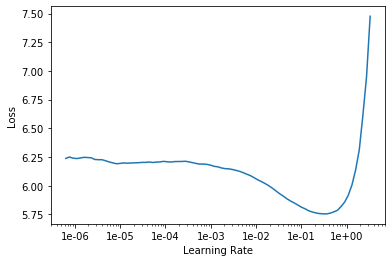

In [13]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [14]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.091238,3.881938,0.325186,05:10
1,3.837670,3.773503,0.337266,05:10


In [15]:
learn.save('language_model')
learn.load('language_model')

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.542131,3.576930,0.361807,05:13
1,3.421527,3.526504,0.369241,05:13


We could probably train the model a bit more, but a ~37% accuracy for predicting the next word in the sentence, when there are over 20k words to choose from, is definitely sufficient for our purpose.<br>
We only need the encoder of the model, which is basically just a mathematical representation of the language. The second part of the model, the decoder, is mostly used for applying that mathematical representation to try to predict the next word in a given sentence.<br>
In order to check out how well our model works, besides just looking at the accuracy metric, we can let it do exactly that. Give it a few words and see whether the model generates sensible sentences.

In [19]:
learn.save('fine_tuned_lm')

In [1]:
learn.load('fine_tuned_lm')

In [22]:
learn.save_encoder('fine_tuned_enc')

In [23]:
# export model to have it saved forevz
learn.export()
# learn = load_learner(path=path, file='trained_on_50k.pkl')

In [25]:
TEXT = "Emily is the greatest"
N_WORDS = 40
N_SENTENCES = 5
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Emily is the greatest tourist in the world xxbos So nice to see Kevin Durant play xxbos Finally going to sleep . Contemplating the day ! xxbos With the 9th pick in the 2018 NBA Draft

Emily is the greatest Chicago girl ever . xxbos Well , you knew what you meant for Cleveland . What ’s wrong with your comments ? Because you ’re talking about the Wizards . Fuck Scott

Emily is the greatest woman to be a xxbos Great game for James Harden and the Houston Rockets . 
 
  We have a confirmed dead - 142 OT loss to Houston Rockets . #

Emily is the greatest NBA player in Chicago Bulls history . She will be in a 62 million dollar Chicago Bulls jersey . She is the better player in the world and i will be happy for

Emily is the greatest Sacramento Kings player of all time . ( via @raptorsrapture )   … xxbos Just turned the Golden State Warriors into a conference finals xxbos Happy Sunday ! ! ! Enjoy


...aaand it seems to work quite well! Two things are especially cool to see for me:
1) It's a nice mix between general babble regarding the NBA (greatest tourist in the world / greatest NBA player in Chicago Bulls history)
2) The model gets the pronouns right. I ran some other sentences with male/female names and the model almost always got the pronouns in the sentences correct.

## Train the classifier
Now that we have a language model we can build our classifier on top of it. For that we will use the vocab from the previously created databunch, our labelled dataset and the encoder of our language model.


In [26]:
data_clas = (TextList.from_df(twitter_sent, cols='text', vocab=data_lm.vocab)
 .split_by_rand_pct(0.2)
 .label_from_df('target')
 .databunch())

In [27]:
data_clas.show_batch(5)

text,target
xxbos lol xxup re - xxup pu - b - l - i - xxup can xxup the xxup demo - c - xxup xxunk xxup tho ;-) xxup thx xxup just - xxup us lol xxup all xxunk xxup wfg xxup thor - xxup tee - y xxup de - xxup luxe - xxup ey ;-) xxup spd xxup xxunk / xxup csu b - xxup xxunk xxup fdp,4
xxbos # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day,4
"xxbos xxup toothache xxup still xxup present , 13 xxup days xxup til i xxup can xxup have xxup another xxup glass xxup of xxup wine , xxup or a xxup beer xxup if i xxup choose . 15 xxup days xxup til i xxup visit xxup vv ... 17 xxup days xxup no xxup jen",0
xxbos xxmaj had a xxmaj lovely xxmaj evening xxmaj last xxmaj night ! ! xxmaj ca nt xxmaj wait xxmaj to xxmaj see xxmaj some xxmaj one xxmaj special ! ! xxmaj has xxmaj work 12 - 8 xxmaj ca nt xxmaj wait xxmaj to xxmaj go xxmaj holiday xxmaj shopping ! ! ! xoxoxox,0
xxbos xxmaj best of xxmaj youtube : xxup the xxup birds & & xxup the xxup bees : xxup the xxup birds & & xxup the xxup bees xxup subscirb xxrep 4 e & & leave a comment / make a video te http : / / is.gd / xxunk,4


In [28]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (100000 items)
x: TextList
xxbos i miss nikki nu nu already she s always there when needed thank u xxx,xxbos xxmaj so i had a dream last night . i remember a sign which clearly told me where to get a job . i ca n't xxunk what the sign said .,xxbos xxunk ohh poor sickly you ( ( ( hugs ) ) hope you feel a little better soon,xxbos it is raining again,xxbos @misskeribaby wish i was in xxup la right now
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (25000 items)
x: TextList
xxbos xxmaj annoyed that i saw great buys but did n't make any purchases,xxbos @juanbarnard hehehe i was not joking ! halo is on now ! !,xxbos i just got an ipod touch going outside for a while,xxbos @cinemabizarre http : / / twitpic.com / xxunk - i want this album ! ! ! in my country .. do not sell the disks !,xxbos @kattpackallday but xxup nc be da shit doe ... xxrep 4 & i put dat xxmaj on my mama
y: CategoryList
0,4,4,0,4
Path: .;

Test: None, model=Sequentia

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


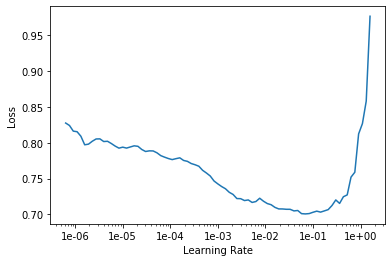

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(1, 1e-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.544355,0.498253,0.755560,01:11


In [31]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-03/(2.6**4),1e-03), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.504515,0.465929,0.777600,01:10


In [32]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-03/(2.6**4),5e-03), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.478471,0.431738,0.801080,01:13
1,0.426770,0.399976,0.817400,01:06
2,0.379781,0.391577,0.820560,01:11


In [35]:
learn.unfreeze()
learn.fit_one_cycle(12, slice(5e-04/(2.6**4),5e-04), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.334869,0.392459,0.823960,01:17
1,0.340859,0.390590,0.823640,01:22
2,0.356315,0.392238,0.824000,01:13
3,0.347060,0.393220,0.824280,01:15
4,0.329250,0.396836,0.823440,01:16
5,0.326283,0.396551,0.824840,01:14
6,0.297403,0.404612,0.825560,01:13
7,0.290198,0.401946,0.825480,01:13
8,0.295075,0.410358,0.824960,01:21
9,0.288201,0.406411,0.824360,01:20


## Model performance

The accuracy seems to plateau at about 82.5%, which is decent enough. 
It's important to point out that the underlying dataset is automatically labelled, solely based on the emojis used. We might get some better results when using datasets which are labelled by humans.<br>
This should be good enough however to score all the NBA tweets, which is done in the code cells below.<br>
The exploratory analysis of the sentiment for each team can be found in the notebook "nba_exploratory_analysis".

In [38]:
learn.export()

In [65]:
# learn = load_learner(path=path, file='trained_on_50k.pkl')
learn.predict("This is amazing")

(Category 4, tensor(1), tensor([0.0090, 0.9910]))

In [90]:
all_nba = (pd.read_csv('team_tweets.csv', engine='python')
              .dropna()
              .reset_index(drop=True).drop(['index'], axis=1))

data_clas.add_test(all_nba)

In [81]:
start = time.time()
predictions, _ = learn.get_preds(ds_type=DatasetType.Test)
end = time.time()
print(f'It took ~{(end-start)/60:.2f} minutes to score all {all_nba.shape[0]} tweets.')

It took ~3.23 minutes to score all 254624 tweets.


In [92]:
output_df = all_nba.join(pd.DataFrame(np.array(predictions), 
                         columns=['probability_negative', 'probability_positive']))

In [95]:
output_df.to_csv('tweets_scored.csv.csv', index=False)